<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT23/blob/main/Lab5/reinisfreibergs_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: differential equations
**Reinis Freibergs**

# **Abstract**

In this lab assignment the goal is to implement and test methods for numerically solving differential equations. Specifically the explicit or forward Euler method is tested and its accuracy and stability properties are evaluated while solving a linear initial value problem and a system of initial value problems describing oscillations of an elastic spring.


# **About the code**

In [152]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""


# Author: Reinis Freibergs, 2023

# Based on a template:
# Copyright (C) 2023 Johan Hoffman (jhoffman@kth.se)


# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [2]:
# Load neccessary modules.
#from google.colab import files

import numpy as np
import matplotlib.pyplot as plt

# **Introduction**

The scalar initial value problem is given by an ordinary differential equation (ODE) with a scalar initial condition:

$$\dot{u} = f(u(t), t) \\ 
u(0) = u_0
$$

Systems of initial value problems are defined the same way, except that now the function $u$ is a vector function. 
To compute them numerically various finite difference schemes can be used. In general, these methods use function values at the endpoints of each time step described by the $\theta$ method:

$$
U_n = U_{n-1} + \frac{k}{2}((1-\theta)f(U_{n-1}, t_{n-1}) + \theta f(U_n, t_n))
$$

Where $k$ is the time step and $\theta$ describes the method. The explicit Euler method is attained with $\theta = 0$ and it computes the approximate solution $U_n$ from the previous time step $U_{n-1}$. This scheme will be used in the further applications since its simple to implement and has unstable behaviour which can be investigated.

# **Methods**

The function below is based on algorithm 13.1 and is written such that both single and systems of initial value problems can be solved.


In [129]:
def explicit_euler_system(f, u0, T, k):

    steps = np.arange(0, T, k)
    
    function_shape = len(u0) if isinstance(u0, np.ndarray) else 1
    function_values = np.zeros((function_shape, len(steps)), dtype=np.complex_)
    function_values[:, 0] = u0

    for i in range(len(steps)-1):
        function_values[:, i+1] = function_values[:, i] + k*f(function_values[:, i])

    return function_values, steps

## Results

### Time stepping for scalar initial value problem

The method is tested with the linear problem 13.12:

$$
\dot{u}(t) = \lambda u(t), \quad 0<t<=T \\
u(0) = 1
$$

Which is tipically used for stability analysis. Its exact solution is given by $u(t) = e^{\lambda t}$, where $\lambda$ is a complex number with negative real part $Re(\lambda) < 0$

A time stepping method with a constant step $k$ is considered A-stable if it converges to zero as $t  \rightarrow 0$ the same as the exact solution. For the explicit Euler method considered here this condition is achieved if $\vert 1 + k\lambda \vert < 1$, which describes the unit circle in the complex plane with radius 1 and origin at -1, implying that the method is only conditionally stable.

To simplify the analysis we can test only real $\lambda$ values. Then the stability condition is

$$
-1 < 1 + \lambda k < 1 \\
k < \frac{-2}{\lambda}
$$

To actually test this the linear problem is solved with various $\lambda$ values centered around the theoretical stability condition and the stability and accuracy of the solution is measured.

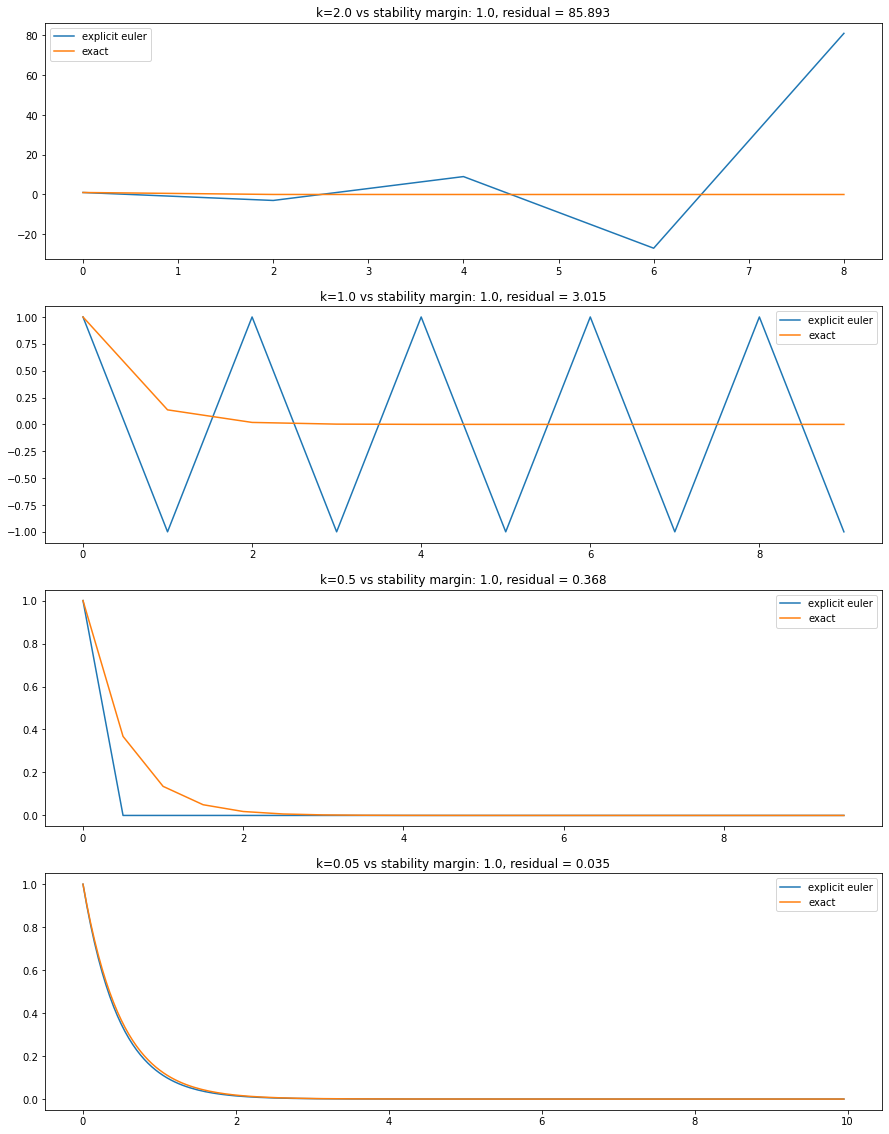

In [130]:
def test_function(lambda_var):
    
    def func(x):
        return lambda_var*x 

    def solution(x):
        return np.exp(lambda_var*x)

    return func, solution

fig, axs = plt.subplots(4, figsize=(15,20))
lambda_var = -2
stability_margin = -2/lambda_var
for idx, k in enumerate([stability_margin*2, stability_margin, stability_margin/2, stability_margin/20]):
    
    function, exact_sol = test_function(lambda_var)
    solution_points, steps = explicit_euler_system(f=function, u0=1, T=10, k=k)
    residual = np.linalg.norm(solution_points - exact_sol(steps)) / np.linalg.norm(exact_sol(steps))
    axs[idx].plot(steps, solution_points.real.squeeze(), label='explicit euler')
    axs[idx].plot(steps, exact_sol(steps).real.squeeze(), label='exact')
    axs[idx].set_title(f'k={k} vs stability margin: {stability_margin}, residual = {round(residual, 3)}')
    axs[idx].legend()

### Time stepping for a system of initial value problems

To test the solution for a system of initial value problems the harmonic oscillator will be used, described in example 14.2.
The differential equation describing extension of an elastic spring is given by the Newton's second law:

$$
m\ddot{x} = F = -kx_1 
$$

where the force $F$ is given by Hooke's law and $k$ is the stifness of the spring. As the acceleration in this equation represents second derivative it can be formulated as a system of two first order initial value problems:

$$
\dot{x}(t) = v(t) \\
\dot{v}(t) = \frac{-k}{m}x(t)
$$

with a solution:

$$
x(t) = A sin(\omega t + \varphi) \\
v(t) = A \omega cos(\omega t + \varphi)
$$

Which in the case of initial conditions $x(0) = 0m$, $v(0) = 10 \frac{m}{s}$ and parameters $k = 0.1 \frac{N}{mm}$, $m = 0.1kg$ gives values:

$$
\varphi = 0 \\
A = \frac{10}{\sqrt{\frac{k}{m}}} = 1 m 
$$

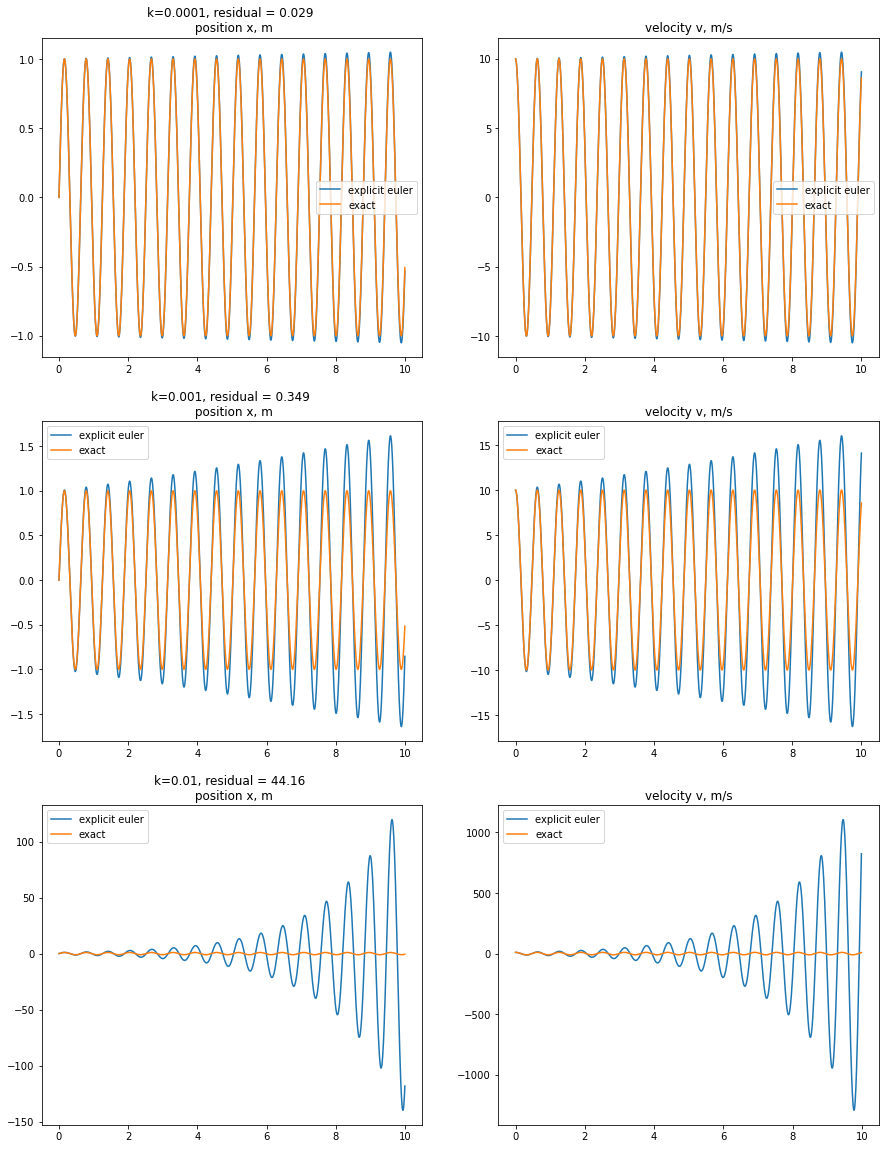

In [131]:
def spring_function(k, m):

    def func(x):
        return np.array([x[1], -k/m*x[0]])

    def solution(x):
        return np.array([1*np.sin(10*x[0]), 1*10*np.cos(10*x[1])])

    return func, solution

fig, axs = plt.subplots(3,2,figsize=(15,20))
for idx, k in enumerate([0.0001, 0.001, 0.01]):
    k_stiff, m = 10, 0.1
    function, exact_sol = spring_function(k_stiff, m)
    solution_points, steps = explicit_euler_system(f=function, u0=np.array([0, 10]), T=10, k=k)
    residual = np.linalg.norm(solution_points - exact_sol(np.stack([steps, steps]))) / np.linalg.norm(exact_sol(np.stack([steps, steps])))
    axs[idx,0].plot(steps, solution_points[0].real, label='explicit euler')
    axs[idx,1].plot(steps, solution_points[1].real, label='explicit euler')
    axs[idx,0].plot(steps, exact_sol(np.stack([steps, steps]))[0].real, label='exact')
    axs[idx,1].plot(steps, exact_sol(np.stack([steps, steps]))[1].real, label='exact')
    axs[idx, 0].set_title(f'k={k}, residual = {round(residual, 3)} \n position x, m')
    axs[idx, 1].set_title('velocity v, m/s')
    axs[idx, 0].legend()
    axs[idx, 1].legend()

# **Discussion**

The test function for the scalar initial value problem showed the expected results - the stability condition of the explicit Euler method determines the minimum step size for solution to converge, otherwise the solutions 'explode'. Step sizes below the critical stability condition can succesfully reduce the residual, but a further comparison with other methods (implicit and trapezoidal for example) would give a better evaluation.

Considering the harmonic oscillator, in this configuration it doesn't have damping parameters, so the amplification observable with larger time steps $k$ in the numerical calculation is due to the method itself not conserving energy.

Both experiments showed that the explicit Euler method can be used to find solutions to initial value problems, but that it also has problems with stability. In contrast from theory the trapezoidal and implicit Euler methods are unconditionally stable,  meaning that the steps can be arbitrary long. But still due to the simplicity of the explicit method it is useful, for example, possibly converted to a predictor-corrector method.